<a href="https://colab.research.google.com/github/zong006/object_detection/blob/main/object_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/tensorflow/models.git


Cloning into 'models'...
remote: Enumerating objects: 96982, done.
remote: Counting objects: 100% (262/262), done.
remote: Compressing objects: 100% (152/152), done.
remote: Total 96982 (delta 116), reused 241 (delta 109), pack-reused 96720
Receiving objects: 100% (96982/96982), 611.09 MiB | 15.20 MiB/s, done.
Resolving deltas: 100% (70534/70534), done.


In [2]:
!cd models/research/ && protoc object_detection/protos/*.proto --python_out=.

In [3]:
!cd models/research/ && cp object_detection/packages/tf2/setup.py .

In [4]:
!cd models/research/ && python -m pip install .

Processing /content/models/research
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 57.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 MB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.6/116.6 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 82.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 71.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [5]:
import os
import pathlib
import tensorflow as tf
import cv2

from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

%matplotlib inline



In [6]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [7]:
!wget -nc -O traffic.jpg https://scx1.b-cdn.net/csz/news/800a/2012/lengthofyell.jpg
!wget -nc -O monkeys.jpg https://img.freepik.com/free-photo/beautiful-shot-monkey-family-with-mother-father-baby-monkeys_181624-8203.jpg
!wget -nc -O human_walk_dog.jpg https://c.ndtvimg.com/2019-03/49tmahi_dog-walk_625x300_08_March_19.jpg

--2024-04-16 08:43:30--  https://scx1.b-cdn.net/csz/news/800a/2012/lengthofyell.jpg
Resolving scx1.b-cdn.net (scx1.b-cdn.net)... 37.19.207.34
Connecting to scx1.b-cdn.net (scx1.b-cdn.net)|37.19.207.34|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [image/jpeg]
Saving to: ‘traffic.jpg’

traffic.jpg             [ <=>                ]   7.28K  --.-KB/s    in 0.001s  

2024-04-16 08:43:31 (11.4 MB/s) - ‘traffic.jpg’ saved [7450]

--2024-04-16 08:43:31--  https://img.freepik.com/free-photo/beautiful-shot-monkey-family-with-mother-father-baby-monkeys_181624-8203.jpg
Resolving img.freepik.com (img.freepik.com)... 23.207.202.202, 23.207.202.193, 2600:1408:ec00:1f::1735:23ce, ...
Connecting to img.freepik.com (img.freepik.com)|23.207.202.202|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 88573 (86K) [image/jpeg]
Saving to: ‘monkeys.jpg’

monkeys.jpg         100%[===================>]  86.50K   461KB/s    in 0.2s    

2024-04-16 0

In [8]:
!ls

human_walk_dog.jpg  models  monkeys.jpg  sample_data  traffic.jpg


In [9]:
def download_model(model_url):

  path_to_model_dir = tf.keras.utils.get_file(
    fname = 'ssd_resnet101_v1_fpn_640x640_coco17_tpu-8.tar.gz',
    origin = model_url,
    untar = True)

  path_to_model = path_to_model_dir+'/saved_model'
  model = tf.saved_model.load(path_to_model)

  return model

In [10]:
def download_category_index(label_url):
  path_to_label = tf.keras.utils.get_file(
    fname = 'mscoco_label_map.pbtxt',
    origin = label_url,
    untar = False)

  category_index = label_map_util.create_category_index_from_labelmap(path_to_label, use_display_name=True)

  return category_index

In [11]:
def image_as_array(img_path):
  # target_size=(224, 224)
  # image = cv2.imread(img_path)
  # # image = cv2.resize(image, target_size)
  # image_array = np.array(image)

  return np.array(Image.open(img_path))

In [12]:
def predictions(model, category_index, img_path):


  image_array = image_as_array(img_path)
  image_tensor = tf.convert_to_tensor(image_array)

  # create a batch of images, of batch size = 1 image.
  # because the model expects a batch of images
  input_tensor = image_tensor[tf.newaxis, ...]

  # model outputs a dictionary
  pred = model(input_tensor)

  detections = {k:None for k in pred.keys()}
  for k in pred.keys():
    detections[k]=pred[k].numpy()[0]

  detections['detection_classes'] = detections['detection_classes'].astype(int)


  min_confidence_thresh = 0.25
  image_w_detections = viz_utils.visualize_boxes_and_labels_on_image_array(
                                                    image_array,
                                                    detections['detection_boxes'],
                                                    detections['detection_classes'],
                                                    detections['detection_scores'],
                                                    category_index,
                                                    use_normalized_coordinates=True,
                                                    min_score_thresh= min_confidence_thresh
                                                    )

  return detections, image_w_detections

In [13]:
def show_image(image_w_detections):
  plt.figure(figsize=(10,7))
  plt.imshow(image_w_detections)
  plt.show()
  return

In [14]:
model_url = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet101_v1_fpn_640x640_coco17_tpu-8.tar.gz'
label_url = "https://raw.githubusercontent.com/tensorflow/models/master/research/object_detection/data/mscoco_label_map.pbtxt"


386527459/386527459 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5056/5056 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step


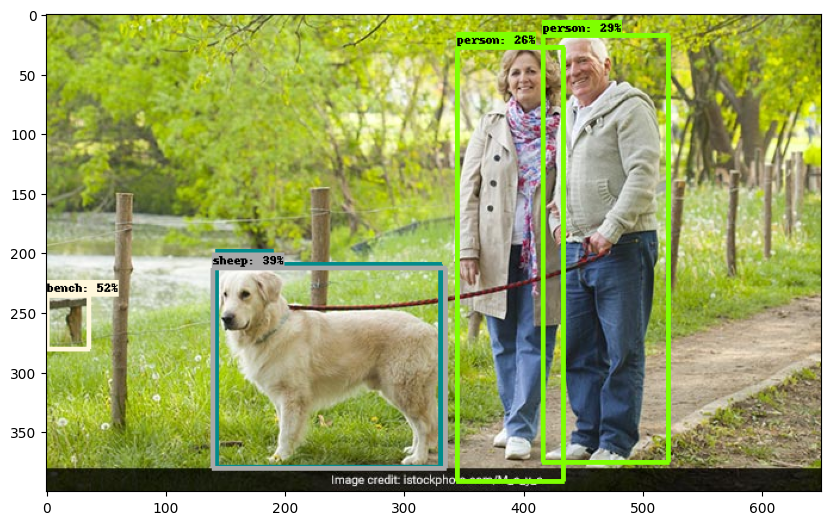

In [15]:
model = download_model(model_url)
category_index = download_category_index(label_url)

detections, image_w_detections = predictions(model, category_index, 'human_walk_dog.jpg')
show_image(image_w_detections)

In [16]:
!wget -nc -O human_walk_dog_2.jpg https://t3.ftcdn.net/jpg/05/36/58/36/240_F_536583618_oK13qs4T36UQDLNLq6IX0fl3nl3qwHDg.jpg
!wget -nc -O football.jpg https://upload.wikimedia.org/wikipedia/commons/4/42/Football_in_Bloomington%2C_Indiana%2C_1995.jpg

--2024-04-16 08:44:33--  https://t3.ftcdn.net/jpg/05/36/58/36/240_F_536583618_oK13qs4T36UQDLNLq6IX0fl3nl3qwHDg.jpg
Resolving t3.ftcdn.net (t3.ftcdn.net)... 151.101.1.167, 151.101.65.167, 151.101.129.167, ...
Connecting to t3.ftcdn.net (t3.ftcdn.net)|151.101.1.167|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 43884 (43K) [image/jpeg]
Saving to: ‘human_walk_dog_2.jpg’

human_walk_dog_2.jp 100%[===================>]  42.86K  --.-KB/s    in 0.01s   

2024-04-16 08:44:33 (3.44 MB/s) - ‘human_walk_dog_2.jpg’ saved [43884/43884]

--2024-04-16 08:44:33--  https://upload.wikimedia.org/wikipedia/commons/4/42/Football_in_Bloomington%2C_Indiana%2C_1995.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.154.240, 2620:0:861:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.154.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6378349 (6.1M) [image/jpeg]
Saving to: ‘football.jpg’

football.jpg        100

In [17]:
!ls

football.jpg	      human_walk_dog.jpg  monkeys.jpg  traffic.jpg
human_walk_dog_2.jpg  models		  sample_data


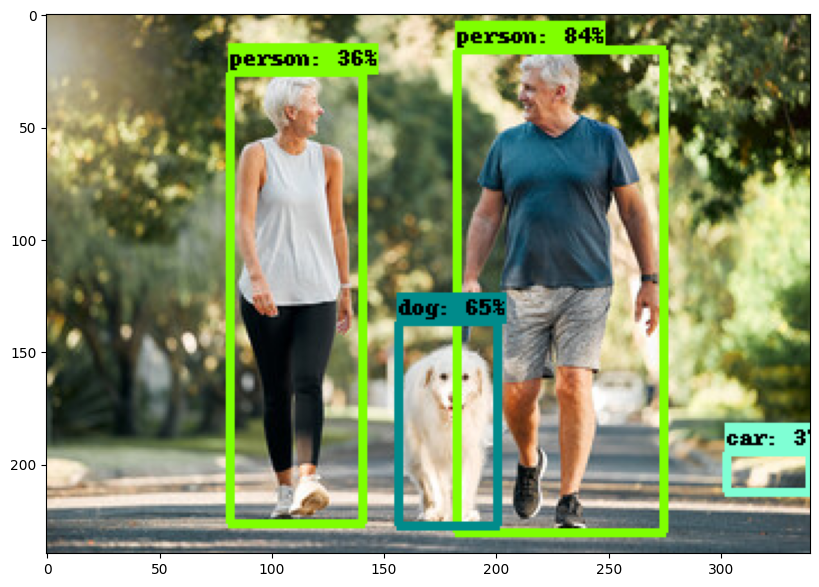

In [18]:
detections, image_w_detections = predictions(model, category_index, 'human_walk_dog_2.jpg')
show_image(image_w_detections)

In [19]:
def get_detected_classes(category_index, detection_classes):

  return set([category_index[i]['name'] for i in detection_classes])


In [20]:
detection_classes = detections['detection_classes']

get_detected_classes(category_index, detection_classes)


{'backpack',
 'baseball bat',
 'baseball glove',
 'bench',
 'bicycle',
 'boat',
 'bottle',
 'bowl',
 'bus',
 'car',
 'chair',
 'cup',
 'dog',
 'frisbee',
 'handbag',
 'person',
 'potted plant',
 'remote',
 'sheep',
 'skateboard',
 'sports ball',
 'suitcase',
 'tennis racket',
 'toilet',
 'toothbrush',
 'truck',
 'umbrella'}